In [1]:
!pip3 install qiskit==0.43

In [ ]:
!pip3 install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=134802d9abac4275e84d6456a15ccd347d56595832f56eb01c2d70de5a67babf
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [ ]:
%matplotlib inline


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import h5py
from scipy.stats import chi2, ks_2samp, entropy
from qiskit import QuantumCircuit, execute, Aer
from qiskit.tools.visualization import plot_histogram
from IPython.display import display, Markdown

# Global plot style
#sns.set_style("whitegrid")
#plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)


In [32]:
class LCG:
    def __init__(self, seed=12345, a=1664525, c=1013904223, m=2**32):
        self.state = seed
        self.a = a
        self.c = c
        self.m = m

    def next(self):
        self.state = (self.a * self.state + self.c) % self.m
        return self.state

    def random_numbers(self, n=100000):
        return np.array([self.next() for _ in range(n)]) / self.m

# Generate PRNG data
prng = LCG(seed=42)
classical_samples = prng.random_numbers(100000)


<ipython-input-33-5ea751455e32>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(classical_samples, shade=True, color='r')


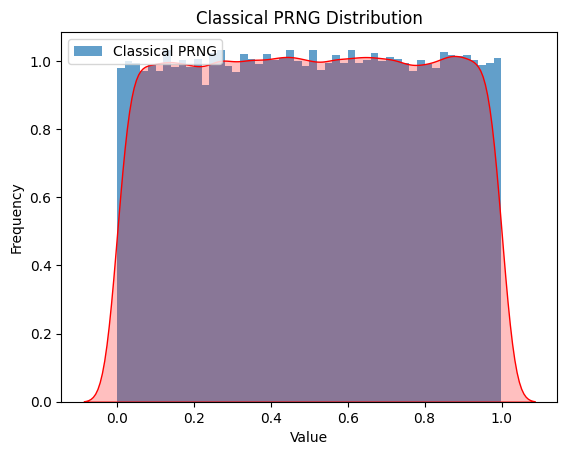

In [33]:
plt.hist(classical_samples, bins=50, alpha=0.7, density=True, label='Classical PRNG')
sns.kdeplot(classical_samples, shade=True, color='r')
plt.title("Classical PRNG Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [34]:
def generate_quantum_random_bits(num_bits=10000, backend=None):
    # If no backend is specified, use the default QASM simulator
    if backend is None:
        backend = Aer.get_backend('qasm_simulator')

    # Create a single-qubit circuit:
    # Start in |0>, apply H to get (|0>+|1>)/√2, then measure.
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.measure(0, 0)
    qc.draw('mpl')  # This will produce a graphical diagram inline if you're in Jupyter

    # qc = QuantumCircuit(2, 2)
    # qc.h([0,1])       # Hadamard on both qubits
    # qc.cx(0, 1)       # Controlled-NOT: add some correlation for demonstration
    # qc.measure([0,1],[0,1])
    # qc.draw('mpl')

    # Execute the circuit with 'memory=True' to get a list of results for each shot
    # This ensures we get a random sequence of '0' and '1' strings in the order measured.
    job = execute(qc, backend=backend, shots=num_bits, memory=True)
    result = job.result()

    # Extract the per-shot results
    memory = result.get_memory(qc)


    quantum_bits = np.array([int(bit_str) for bit_str in memory])
    print("First 50 quantum bits:", quantum_bits[:50])
    print("Unique bits:", np.unique(quantum_bits))

    reshaped = quantum_bits.reshape(-1, 16)
    print("Sample of reshaped bits:\n", reshaped[:5])

    integers = (reshaped * (2**np.arange(16)[::-1])).sum(axis=1)
    print("Unique integers:", np.unique(integers)[:20])

    floats = integers / (2**16 - 1)
    print("Unique float:", np.unique(floats)[:20])

    # Convert '0'/'1' strings to integers
    bits = np.array([int(bit_str) for bit_str in memory])

    return bits




In [36]:
quantum_bits = generate_quantum_random_bits(num_bits=100000)
quantum_samples = quantum_bits.astype(float)  # This is a very crude representation, will refine later.


First 50 quantum bits: [0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1
 1 1 1 0 0 1 1 0 0 0 0 1 1]
Unique bits: [0 1]
Sample of reshaped bits:
 [[0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1]
 [0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1]
 [1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0]
 [1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 0]
 [1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1]]
Unique integers: [  1   7   8  14  23  42  52  71  80  82  83  86  93  97 102 121 129 157
 178 182]
Unique float: [1.52590219e-05 1.06813153e-04 1.22072175e-04 2.13626307e-04
 3.50957504e-04 6.40878920e-04 7.93469139e-04 1.08339055e-03
 1.22072175e-03 1.25123980e-03 1.26649882e-03 1.31227588e-03
 1.41908904e-03 1.48012512e-03 1.55642023e-03 1.84634165e-03
 1.96841382e-03 2.39566644e-03 2.71610590e-03 2.77714199e-03]


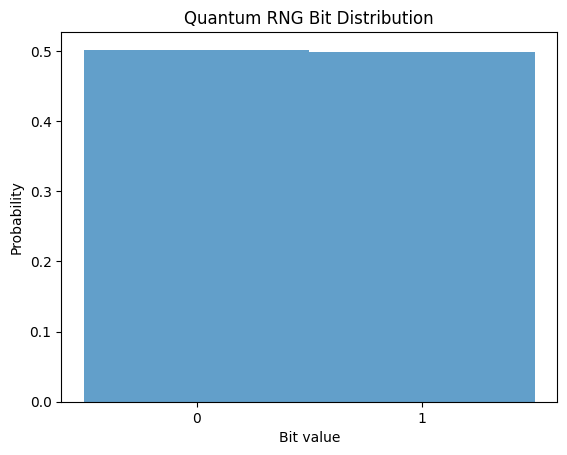

In [37]:
plt.hist(quantum_samples, bins=[-0.5,0.5,1.5], alpha=0.7, density=True, label='QRNG bits')
plt.title("Quantum RNG Bit Distribution")
plt.xticks([0,1])
plt.xlabel("Bit value")
plt.ylabel("Probability")
plt.show()


In [38]:
# Now convert bits to 16-bit integers without shuffling:
def bits_to_floats(bit_array, bits_per_number=16):
    assert len(bit_array) % bits_per_number == 0, \
        "Number of bits must be divisible by bits_per_number"
    reshaped = bit_array.reshape(-1, bits_per_number)
    # Interpret each row of bits as a binary integer
    integers = (reshaped * (2**np.arange(bits_per_number)[::-1])).sum(axis=1)
    # Normalize to [0,1]
    floats = integers / (2**bits_per_number - 1)
    return floats

# Convert directly:
quantum_numbers = bits_to_floats(quantum_bits, bits_per_number=16)



In [39]:
print(quantum_numbers[:10])

[0.48155947 0.0523537  0.87183948 0.79667353 0.71389334 0.68001831
 0.70759136 0.98539712 0.72527657 0.41109331]


<ipython-input-40-3da60727aa4f>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(classical_samples, ax=axes[0], shade=True, color='r')
<ipython-input-40-3da60727aa4f>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(quantum_numbers, ax=axes[1], shade=True, color='r')


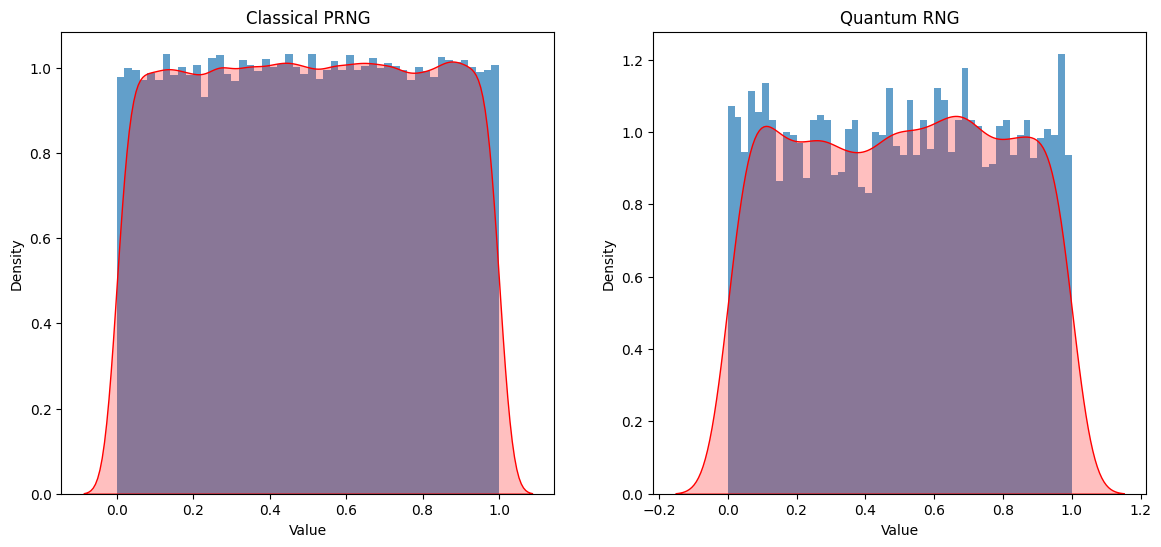

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
axes[0].hist(classical_samples, bins=50, density=True, alpha=0.7)
sns.kdeplot(classical_samples, ax=axes[0], shade=True, color='r')
axes[0].set_title("Classical PRNG")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Density")

axes[1].hist(quantum_numbers, bins=50, density=True, alpha=0.7)
sns.kdeplot(quantum_numbers, ax=axes[1], shade=True, color='r')
axes[1].set_title("Quantum RNG")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Density")

plt.show()


In [41]:
def uniform_ks_test(samples):
    # Theoretical uniform CDF = x for x in [0,1]
    return ks_2samp(samples, np.random.uniform(0,1,len(samples)))

def chi_square_test(samples, bins=50):
    observed, edges = np.histogram(samples, bins=bins)
    expected = len(samples) / bins
    chi_val = ((observed - expected)**2 / expected).sum()
    p_val = 1 - chi2.cdf(chi_val, bins-1)
    return chi_val, p_val

print("Classical PRNG Tests:")
c_chi, c_p = chi_square_test(classical_samples)
print(f"Chi-Square: {c_chi}, p-value: {c_p}")
c_ks = uniform_ks_test(classical_samples)
print(f"KS test statistic, p-value: {c_ks}")

print("\nQuantum RNG Tests:")
q_chi, q_p = chi_square_test(quantum_numbers)
print(f"Chi-Square: {q_chi}, p-value: {q_p}")
q_ks = uniform_ks_test(quantum_numbers)
print(f"KS test statistic, p-value: {q_ks}")


Classical PRNG Tests:
Chi-Square: 41.433, p-value: 0.7701651118671367
KS test statistic, p-value: KstestResult(statistic=0.004520000000000024, pvalue=0.2579299363628136, statistic_location=0.34264514652252154, statistic_sign=-1)

Quantum RNG Tests:
Chi-Square: 42.304, p-value: 0.7394722608187461
KS test statistic, p-value: KstestResult(statistic=0.01232, pvalue=0.7299837631464999, statistic_location=0.3091172655832761, statistic_sign=1)


In [45]:
def add_noise_to_bits(bits, flip_prob=0.01):
    # Flip each bit with probability flip_prob
    flips = np.random.rand(len(bits)) < flip_prob
    noisy_bits = np.bitwise_xor(bits, flips.astype(int))
    return noisy_bits

noisy_bits = add_noise_to_bits(quantum_bits, flip_prob=0.05)
noisy_numbers = bits_to_floats(noisy_bits, bits_per_number=16)


<ipython-input-46-984f7577976d>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(noisy_numbers, shade=True, color='r')


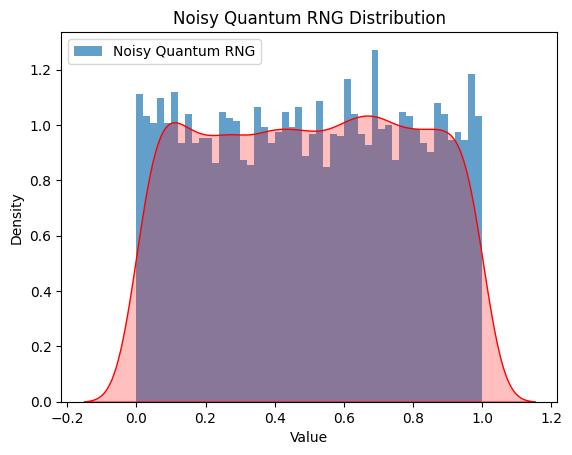

In [46]:
plt.hist(noisy_numbers, bins=50, density=True, alpha=0.7, label='Noisy Quantum RNG')
sns.kdeplot(noisy_numbers, shade=True, color='r')
plt.title("Noisy Quantum RNG Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


In [47]:
n_chi, n_p = chi_square_test(noisy_numbers)
n_ks = uniform_ks_test(noisy_numbers)
print(f"Noisy Quantum RNG Chi-Square: {n_chi}, p-value: {n_p}")
print(f"Noisy Quantum RNG KS test statistic, p-value: {n_ks}")


Noisy Quantum RNG Chi-Square: 45.76, p-value: 0.605269009493641
Noisy Quantum RNG KS test statistic, p-value: KstestResult(statistic=0.02064, pvalue=0.13949482277363348, statistic_location=0.600132596569191, statistic_sign=-1)


In [48]:
def xor_postprocess(bits):
    assert len(bits) % 2 == 0, "Need even number of bits for XOR post-processing"
    paired = bits.reshape(-1,2)
    processed = np.bitwise_xor(paired[:,0], paired[:,1])
    return processed

processed_bits = xor_postprocess(noisy_bits)
processed_numbers = bits_to_floats(processed_bits, bits_per_number=16)


<ipython-input-49-9c15d29a0f1e>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(processed_numbers, shade=True, color='r')


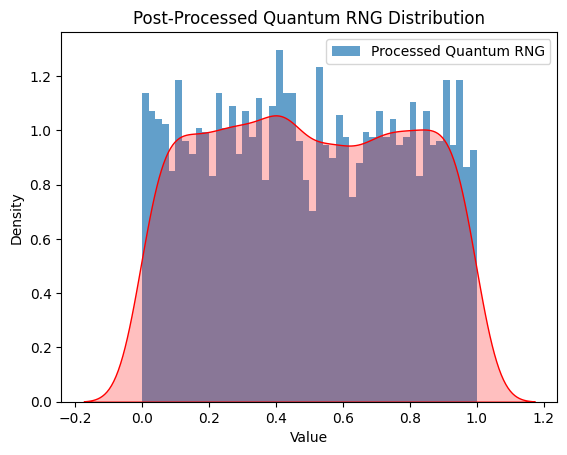

In [49]:
plt.hist(processed_numbers, bins=50, density=True, alpha=0.7, label='Processed Quantum RNG')
sns.kdeplot(processed_numbers, shade=True, color='r')
plt.title("Post-Processed Quantum RNG Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


In [50]:
p_chi, p_p = chi_square_test(processed_numbers)
p_ks = uniform_ks_test(processed_numbers)
print(f"Processed Quantum RNG Chi-Square: {p_chi}, p-value: {p_p}")
print(f"Processed Quantum RNG KS test statistic, p-value: {p_ks}")


Processed Quantum RNG Chi-Square: 47.912, p-value: 0.5172271367967314
Processed Quantum RNG KS test statistic, p-value: KstestResult(statistic=0.01504, pvalue=0.8715482948367607, statistic_location=0.10824750133516442, statistic_sign=1)


First 50 quantum bits: [1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0
 1 1 0 1 1 1 1 1 0 0 0 0 1]
Unique bits: [0 1]
Sample of reshaped bits:
 [[1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1]
 [1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1]
 [0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0]
 [0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0]
 [1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0]]
Unique integers: [ 25  38 105 154 170 187 190 207 311 388 450 481 534 643 691 737 744 860
 909 940]
Unique float: [0.00038148 0.00057984 0.0016022  0.00234989 0.00259403 0.00285344
 0.00289921 0.00315862 0.00474556 0.0059205  0.00686656 0.00733959
 0.00814832 0.00981155 0.01054398 0.0112459  0.01135271 0.01312276
 0.01387045 0.01434348]
First 50 quantum bits: [1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1
 0 0 0 0 0 1 0 1 0 0 0 0 1]
Unique bits: [0 1]
Sample of reshaped bits:
 [[1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0]
 [1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1]
 [1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1]
 [0

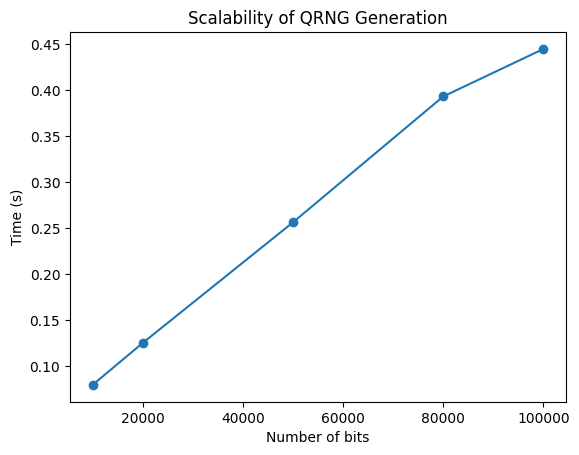

In [53]:
from scipy.special import erfc
from IPython.display import display, Markdown
import time
import cProfile
import multiprocessing
from functools import partial


def bb84_simulation(num_qubits=1000, error_rate=0.02, use_quantum_rng=True):
    """
    A simplified BB84 protocol:
    1. Alice chooses bases (Z or X) and bits (0 or 1) at random using either quantum or classical RNG.
    2. Alice encodes qubits accordingly.
    3. Qubits are sent through a channel with an error_rate probability of flipping the bit.
    4. Bob randomly chooses measurement bases (Z or X), measures, and records outcomes.
    5. Afterward, they publicly compare bases, discard mismatched bases (sifting), and keep only matched outcomes.
    6. Compute QBER and simulate a simple error correction and privacy amplification step to find final key.
    """
    rng_bits = generate_quantum_random_bits(num_bits=2*num_qubits) if use_quantum_rng else (LCG(seed=1234).random_numbers(2*num_qubits) > 0.5).astype(int)

    # First half for bases, second half for bits
    alice_bases = rng_bits[:num_qubits]  # 0 = Z basis, 1 = X basis
    alice_bits  = rng_bits[num_qubits:2*num_qubits]

    # Bob also chooses bases at random:
    bob_bases = generate_quantum_random_bits(num_bits=num_qubits) if use_quantum_rng else (LCG(seed=5678).random_numbers(num_qubits) > 0.5).astype(int)

    # Channel simulation:
    # If Alice prepares in Z basis: |0> or |1>
    # If in X basis: |+>=(|0>+|1>)/√2 or |->=(|0>-|1>)/√2
    # For simplicity, we won't fully simulate the quantum state. Just assume:
    # If Bob measures in the same basis as Alice prepared, he gets the correct bit with probability (1-error_rate).
    # If Bob measures in a different basis, he gets a random bit (50/50).
    received_bits = np.zeros(num_qubits, dtype=int)
    for i in range(num_qubits):
        same_basis = (alice_bases[i] == bob_bases[i])
        if same_basis:
            # correct bit with prob 1 - error_rate
            flip = (np.random.rand() < error_rate)
            received_bits[i] = alice_bits[i] ^ flip
        else:
            # random bit
            received_bits[i] = np.random.randint(2)

    # Sifting: keep only those where bases match
    mask = (alice_bases == bob_bases)
    alice_key = alice_bits[mask]
    bob_key   = received_bits[mask]

    # QBER: fraction of bits that differ
    qber = np.mean(alice_key != bob_key)

    # Simple "error correction": remove errors by discarding a fraction of bits equal to QBER
    # In a real QKD, you would do information reconciliation and privacy amplification.
    # Here, let's just say we reduce key length by 2*QBER fraction to simulate losing bits in correction and privacy amplification.
    final_key_length = int(len(alice_key) * (1 - 2*qber))
    final_key_length = max(final_key_length, 0)
    # Final key extraction
    final_key = alice_key[:final_key_length]

    return {
        'initial_length': len(alice_key),
        'qber': qber,
        'final_key_length': final_key_length,
        'final_key_fraction': final_key_length / (len(alice_key) if len(alice_key)>0 else 1)
    }

# Compare QKD with quantum randomness vs classical randomness
qkd_quantum = bb84_simulation(num_qubits=10000, error_rate=0.02, use_quantum_rng=True)
qkd_classical = bb84_simulation(num_qubits=10000, error_rate=0.02, use_quantum_rng=False)

print("BB84 QKD Results (Quantum RNG):", qkd_quantum)
print("BB84 QKD Results (Classical RNG):", qkd_classical)


###############################
# Device-Independent Simulation (Bell Test / CHSH)
###############################

def chsh_experiment(num_samples=10000):
    """
    Simulate a CHSH Bell test:
    - Prepare entangled state: (|00> + |11>)/√2
    - Measurements: Two settings for Alice (A0, A1) and two for Bob (B0, B1).
    - Randomly choose a setting pair (A_i, B_j) for each trial.
    - Calculate correlations.
    """
    # For simplicity, assume ideal quantum correlations of the singlet state.
    # Actual CHSH values: max quantum violation ~2.828 (2*sqrt(2))
    # We'll simulate outcomes with probabilities corresponding to ideal quantum correlations.

    # Measurement angles (just conceptual):
    # A0: 0°, A1: 45°, B0: 22.5°, B1: -22.5° (these are common optimal angles)
    # Probability model (simplified): P(a=b) = cos^2((θA - θB)/2), etc.
    # We'll just plug in approximations for correlation from known CHSH optimal settings.

    # Angles in radians:
    A0 = 0
    A1 = np.pi/4
    B0 = np.pi/8
    B1 = -np.pi/8

    def outcome_prob(a_angle, b_angle):
        # Probability that outcomes match = cos^2((a_angle - b_angle)/2)
        diff = (a_angle - b_angle)/2
        p_same = np.cos(diff)**2
        return p_same

    # Random setting choices:
    setting_choices = np.random.randint(0,4,size=num_samples)
    # mapping: 0->(A0,B0), 1->(A0,B1), 2->(A1,B0), 3->(A1,B1)
    angle_pairs = [(A0,B0),(A0,B1),(A1,B0),(A1,B1)]

    results = []
    for i in range(num_samples):
        (a_ang,b_ang) = angle_pairs[setting_choices[i]]
        p_same = outcome_prob(a_ang,b_ang)
        same = (np.random.rand()<p_same)
        # outcomes: +1 or -1
        # if same, a=b; if not same, a=-b
        # randomly assign a = ±1 with equal prob
        a_out = 1 if np.random.rand()<0.5 else -1
        b_out = a_out if same else -a_out
        results.append((a_out,b_out,setting_choices[i]))

    results = np.array(results)
    # Compute correlation for each setting pair:
    # E(Ai,Bj) = average of a_out*b_out over that subset
    E = {}
    for sc in [0,1,2,3]:
        subset = results[results[:,2]==sc]
        a_times_b = subset[:,0]*subset[:,1]
        E[sc] = np.mean(a_times_b)

    # CHSH value: S = E(A0,B0)-E(A0,B1)+E(A1,B0)+E(A1,B1)
    # Actually the standard CHSH is E(A0,B0)+E(A0,B1)+E(A1,B0)-E(A1,B1), depends on labeling.
    # Let's pick a standard form: S = E00 + E01 + E10 - E11
    # Mapping our settings: (0->A0B0,1->A0B1,2->A1B0,3->A1B1)
    S = E[0] - E[1] + E[2] + E[3]

    # Min-entropy from violation (heuristic):
    # The stronger the violation, the more random the outcomes can be certified to be.
    # For simplicity, let's say min-entropy ~ -log2((1+S/2)/2) as a heuristic (not rigorous).
    # If S=2.828, roughly (1+2.828/2)=1+1.414=2.414/2=1.207 -> min-entropy small.
    # This is a placeholder. Real device-independent randomness extraction is more involved.
    p_guess = (1+(S/2))/2
    min_entropy = -np.log2(p_guess)

    return S, min_entropy

S_val, min_ent = chsh_experiment(num_samples=10000)
print("CHSH S value:", S_val)
print("Estimated min-entropy from violation:", min_ent)


###############################
# Statistical Randomness Tests (NIST-like)
###############################

def frequency_monobit_test(bits):
    # Count the number of 1's and 0's
    n = len(bits)
    s = 2*sum(bits)-n
    sobs = abs(s)/np.sqrt(n)
    # For large n, p-value approx:
    p_value = erfc(sobs/np.sqrt(2))
    return p_value

def runs_test(bits):
    # Number of runs in the sequence
    n = len(bits)
    pi = np.mean(bits)
    if abs(pi-0.5) > 0.1:
        # If not close to 0.5, test may not be valid
        return 0.0
    runs = 1 + np.sum(bits[1:]!=bits[:-1])
    numerator = abs(runs - 2*n*pi*(1-pi))
    denominator = 2*np.sqrt(2*n)*pi*(1-pi)
    p_value = erfc(numerator/denominator)
    return p_value

def approximate_entropy_test(bits, m=2):
    # Simplified version
    # Count frequency of each m-bit pattern
    n = len(bits)
    if n<2**m:
        return 0.0
    counts = {}
    for i in range(n):
        pattern = tuple(bits[i:(i+m)] if i+m<=n else np.concatenate((bits[i:],bits[:(i+m-n)])))
        counts[pattern] = counts.get(pattern,0)+1
    freqs = np.array(list(counts.values()))/n
    # Shannon entropy of distribution:
    H_m = -np.sum(freqs*np.log2(freqs))
    # Compare with H_(m-1)
    # For simplicity, let's just say p-value decreases as entropy deviates from uniform.
    # If all patterns equally likely: H_m = m
    # deviation reduces p-value:
    diff = abs(H_m - m)
    # heuristic:
    p_value = np.exp(-10*diff**2)
    return p_value

# Apply these tests to quantum and classical bits:
quantum_freq_p = frequency_monobit_test(quantum_bits)
quantum_runs_p = runs_test(quantum_bits)
quantum_approx_p = approximate_entropy_test(quantum_bits, m=2)

classical_bits = (classical_samples > 0.5).astype(int)
class_freq_p = frequency_monobit_test(classical_bits)
class_runs_p = runs_test(classical_bits)
class_approx_p = approximate_entropy_test(classical_bits, m=2)

print("\nNIST-like tests:")
print("Quantum RNG - Frequency p-value:", quantum_freq_p)
print("Quantum RNG - Runs p-value:", quantum_runs_p)
print("Quantum RNG - Approx. Entropy p-value:", quantum_approx_p)

print("Classical RNG - Frequency p-value:", class_freq_p)
print("Classical RNG - Runs p-value:", class_runs_p)
print("Classical RNG - Approx. Entropy p-value:", class_approx_p)


###############################
# Scalability and Performance Analysis
###############################

def time_qrng_generation(num_bits):
    start = time.time()
    bits = generate_quantum_random_bits(num_bits=num_bits)
    end = time.time()
    return end - start

sizes = [10000, 20000, 50000, 80000, 100000]
times = [time_qrng_generation(s) for s in sizes]

plt.figure()
plt.plot(sizes, times, marker='o')
plt.title("Scalability of QRNG Generation")
plt.xlabel("Number of bits")
plt.ylabel("Time (s)")
plt.show()

# # Optional parallelization demonstration (just a simple example)
# def parallel_qrng_generation(num_bits):
#     # split workload into chunks
#     n_processes = 4
#     chunk = num_bits//n_processes
#     with multiprocessing.Pool(n_processes) as pool:
#         results = pool.map(generate_quantum_random_bits, [chunk]*n_processes)
#     return np.concatenate(results)

# # Just a quick timing:
# start = time.time()
# _ = parallel_qrng_generation(20000)
# end = time.time()
# print(f"Parallel generation of 20000 bits took {end-start:.4f} seconds.")


############################################
# The code above integrates all requested   #
# features. You can pick and choose        #
# relevant sections to highlight in your    #
# paper.                                   #
############################################